## Load Land Registry Data

In [11]:
import pandas as pd
from pathlib import Path
import hashlib

DATA_DIR = Path("../data/raw_land_registry")
df = pd.read_csv(f"{DATA_DIR}/TA11.csv")
df["deed_date"] = pd.to_datetime(df["deed_date"])
df["year"] = df["deed_date"].dt.year
address_cols = ["paon", "saon", "street", "locality", "town"]
address = df[address_cols].astype(str).agg(";".join, axis=1)
display(df.head(2))
df["address_hash"] = address.apply(lambda x: hashlib.md5(x.encode()).hexdigest())
display(df.head(2))
# print(df.dtypes)

,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,year
0,F7473CFF-4F88-4FC1-B913-4B900C3D88EB,480000,2011-05-16,TA11 6AA,D,N,F,NaN,HIGHER HURCOT HOUSE,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,2011
1,2333637D-2FAA-4129-9E11-002A9B01CFCF,345000,2015-01-30,TA11 6AA,T,N,F,CALF BARN,HIGHER HURCOTT FARM,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015


,unique_id,price_paid,deed_date,postcode,property_type,new_build,estate_type,saon,paon,street,locality,town,district,county,transaction_category,linked_data_uri,year,address_hash
0,F7473CFF-4F88-4FC1-B913-4B900C3D88EB,480000,2011-05-16,TA11 6AA,D,N,F,NaN,HIGHER HURCOT HOUSE,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,2011,6a69b1579e1c54f9826aca93f036b168
1,2333637D-2FAA-4129-9E11-002A9B01CFCF,345000,2015-01-30,TA11 6AA,T,N,F,CALF BARN,HIGHER HURCOTT FARM,NaN,HURCOT,SOMERTON,SOUTH SOMERSET,SOMERSET,A,http://landregistry.data.gov.uk/data/ppi/trans...,2015,169a639c80ad144f076d2affb7896386


## Open Database Connection

In [2]:
import duckdb


def open_database_connection():
    con = duckdb.connect("../data/house_prices.db")
    con.execute("INSTALL vortex; LOAD vortex;")
    return con

## Write to Vortex

In [4]:
con = open_database_connection()

# Write the polars dataframe to a vortex file
OUT_DIR = Path("../data/vortex")
OUT_DIR.mkdir(exist_ok=True)

# # Write partitioned Vortex dataset
con.execute(f"""
    COPY (
        SELECT * FROM df
        ORDER BY deed_date
    )
    TO '{OUT_DIR / "house_prices.vortex"}'
    (FORMAT VORTEX, COMPRESSION ZSTD)
""")
# (FORMAT VORTEX, PARTITION_BY (year), COMPRESSION ZSTD)

print(f"Vortex dataset written to {OUT_DIR}")

Vortex dataset written to ../data/vortex


## Read from Database

In [5]:
con = open_database_connection()

# Example: Average price per year up to 2023
result = con.execute("""
    SELECT 
        year,
        AVG(price_paid)::INT64 AS avg_price,
        COUNT(*) AS sales_count
    FROM read_vortex('../data/vortex/*.vortex')
    WHERE deed_date < DATE '2024-01-01'
    GROUP BY year
    ORDER BY year
""").df()

print(result.head())

   year  avg_price  sales_count
0  1995      72785           85
1  1996      85976          121
2  1997      83018          103
3  1998      93549          111
4  1999     109570          132


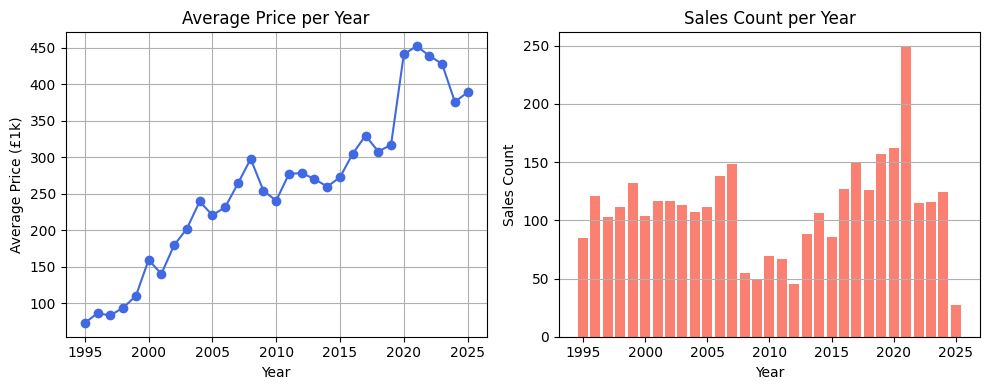

In [6]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Plot average price per year
axs[0].plot(result["year"], result["avg_price"] / 1000, marker="o", color="royalblue")
axs[0].set_title("Average Price per Year")
axs[0].set_xlabel("Year")
axs[0].set_ylabel("Average Price (£1k)")
axs[0].grid(True)

# Plot sales count per year
axs[1].bar(result["year"], result["sales_count"], color="salmon")
axs[1].set_title("Sales Count per Year")
axs[1].set_xlabel("Year")
axs[1].set_ylabel("Sales Count")
axs[1].grid(axis="y")

plt.tight_layout()
plt.show()

# Houses that have 2+ entries

┌───────┐
│   x   │
│ int32 │
├───────┤
│    42 │
└───────┘

